# GSP Final Project
In this notebook, we will demonstrate estimation of graph signals using a GSP-based technique vs.  a deep-learning-based technique. 

In [21]:
import util
import torch
import torch.nn as nn
import numpy as np
import scipy.sparse as ssparse
import scipy.io as sio
import torch_geometric as tg
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [2]:
colab = False
if colab:
    drive_path = './' # For colab integration type here your path and set 'colab = True'
else:
    drive_path = './'

In [10]:
device = 'cpu'

In [3]:
# Enable CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 26 14:52:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   41C    P8              2W /  115W |    1282MiB /   8188MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [23]:
# To empty GPU cache - No need to run
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

## Task

$$\mathbf{x} \longrightarrow  \boxed{\text{Physical Model}} \longrightarrow \mathbf{y}  \longrightarrow \boxed{\text{Estimator}}  \longrightarrow \hat{\mathbf{x}}$$ 

### Physical Model
$$ \mathbf{y} = \mathbf{g}(\mathbf{x};\mathbf{L}) + \mathbf{w} $$

- $\mathbf{x} \sim p(\mathbf{x})$.
- $\mathbf{g}$ - a non-linear measurement function.
- $\mathbf{L}$ - the Laplacian matrix of the graph.
 
### Estimator
- $\mathbf{y}$ - input of the estimator
- $\mathbf{x}$ - ground-truth corresponding label
- The estimator is given a dataset pairs of $\{\mathbf{x_t}, \mathbf{y_t} \}_t$ for training.

**Goal**: The estimator should recover $\mathbf{x}$ out of $\mathbf{y}$ with minimum MSE.
#### GSP-based

Use a GSP-based technique for estimation.

#### GNN-based

Use a GNN deep-learning architecture for estimation.

**NOTE:**  $\mathbf{y}$ is the input to the DP model and $\mathbf{x}$ is the output (i.e., the label) not vise versa!

## Part 1: Physical Model

In [22]:
def laplacian_evd(Y):
    L = - np.imag(Y)
    Lambda, V = np.linalg.eig(L)
    Lambda = np.real(Lambda)
    sorted_indices = np.argsort(Lambda)
    Lambda = Lambda[sorted_indices]
    Lambda = np.diag(Lambda)
    V = V[:, sorted_indices]
    return L, Lambda, V
    
def g_xL(Y, x):
    v = np.exp(1j * x)
    g_x = np.real(v * np.conj(Y @ v))
    return g_x
    
def generate_data(nt, Y, Lambda, V, beta=3, c_ww=0.05):
    N = Y.shape[0]
    xt = (V[:, 1:] @ np.random.multivariate_normal(np.zeros(N - 1), beta * np.diag(1 / np.diag(Lambda)[1:]), nt).T).T
    if nt == 1:
        xt = xt[0, :]
    
    yt = np.zeros(xt.shape)
    for t in range(0, nt):
        yt[t] = g_xL(Y, xt[t])
    yt += np.sqrt(c_ww) * np.random.randn(yt.shape[0], yt.shape[1])
    
    return xt, yt

# filename = 'grid_data_ieee118cdf.mat'
# grid_data = sio.loadmat(filename)
# Y = grid_data['Y']
# N = Y.shape[0]
# nt = 1000
# 
# L, Lambda, V = laplacian_evd(Y)
# xt_train, yt_train = generate_data(nt, Y, Lambda, V, )

## Part 2: GSP-LMMSE Estimator

The GSP-LMMSE estimator is defined as an estimator which minimize the MSE among all estimators in the form of a graph filter:
$$
\{\bf{h}, \bf{b} \} = \text{argmin}~ \mathbb{E} [(\bf{x} - \hat{\bf{x}}(\bf{y}))^2]
$$

where $\hat{\bf{x}}(\bf{y}) =  \bf{V} \text{diag} (\bf{h}) \bf{V}^T \bf{y}+ \bf{b}$.

A closed form expression would be:
$$ \hat{\bf{x}}(\bf{y}) =  \bf{V} \text{diag} (\bf{d}_{\bf{xy}}\oslash \bf{d}_{\bf{yy}}) \bf{V}^T \bf{y} + \bar{\bf{x}}$$

where $\bf{d}_{\bf{xy}} := \text{diag}(\text{cov}(\bf{V}^T \bf{x}, \bf{V}^T \bf{y}))$, $\bf{d}_{\bf{yy}} := \text{diag}(\text{var}(\bf{V}^T \bf{y}))$ and $\bar{\bf{x}} :=\mathbb{E}\bf{x}$

In [23]:
def train_gsp_lmmse_estimator(xt, yt, V):
    xt = xt.T     # column vectors representation
    yt = yt.T     # column vectors representation

    xt_mean = np.mean(xt, axis=1)[:, np.newaxis]
    yt_mean = np.mean(yt, axis=1)[:, np.newaxis]

    d_xy = np.mean( ( V.T @ (xt - xt_mean) ) * ( V.T @ (yt - yt_mean) ) , axis=1)

    d_yy = np.mean( ( V.T @ (yt - yt_mean) ) ** 2 , axis=1)
    
    h = d_xy / d_yy
    
    return h, xt_mean

In [6]:
def test_estimator_mse(h, b, xt_test, yt_test, V):
    xt_test = xt_test.T     # column vectors representation
    yt_test = yt_test.T     # column vectors representation

    err = V @ np.diag(h) @ V.T @ yt_test + b - xt_test
    s_mse = np.linalg.norm(err, axis=0)
    mse = np.mean(s_mse)
    return mse


## Part 3: GNN and Deep Learning based Estimation

### Define Model Architecture

In [7]:
# class GNN(torch.nn.Module):
#     def __init__(self, K = 30 ):  # K is the order of the Chebyshev polynomial
#         super(GNN, self).__init__()
#         
#         self.conv1 = tg.nn.ChebConv(1, 1, K=K, normalization=None)
#         self.relu1 = nn.LeakyReLU()
#         self.conv2 = tg.nn.ChebConv(1, 1, K=K, normalization=None)
#         self.relu2 = nn.ReLU()
#         self.conv3 = tg.nn.ChebConv(1, 1, K=K, normalization=None)  
# 
#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index=edge_index)
#         x = self.relu1(x)
#         x = self.conv2(x, edge_index=edge_index)
#         # x = self.relu2(x)
#         # x = self.conv3(x, edge_index=edge_index)
#         return x
# 
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        # Since input and output features are 1, we set up the intermediate layers with a higher dimension
        # Intermediate dimension for hidden layers
        hidden_dim = 16
        K = 30
        # First GCN layer with 1 input feature and hidden_dim output features
        self.conv1 = tg.nn.ChebConv(1, hidden_dim,  K=K, normalization=None)
        # Second GCN layer
        self.conv2 = tg.nn.ChebConv(hidden_dim, hidden_dim,  K=K, normalization=None)
        # Third GCN layer, outputs hidden_dim features
        self.conv3 = tg.nn.ChebConv(hidden_dim, hidden_dim,  K=K, normalization=None)
        # Output linear layer to reduce back to 1 feature
        self.linear = torch.nn.Linear(hidden_dim, 1, )
        self.relu1 = nn.LeakyReLU()
        self.relu2 = nn.LeakyReLU()
        # self.relu1 = nn.LeakyReLU()

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        # Apply the first convolution
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = self.relu1(x)  
        # x = F.dropout(x, training=self.training)  # Apply dropout to avoid overfitting

        # Apply the second convolution
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        x = self.relu2(x)  
        # x = F.dropout(x, training=self.training)  # Apply dropout to avoid overfitting

        # Apply the third convolution
        x = self.conv3(x, edge_index, edge_weight=edge_weight)
        # x = F.relu(x)

        # Apply a final linear transformation
        x = self.linear(x)

        return x

### Define training function

In order to run on GPU via CUDA set device accordingly.

In [19]:
def train_model(model, train_data, valid_data, batch_size=500, valid_batch_size = 200, epochs=40, lr=0.01, weight_decay=1e-4, path=None, device='cpu'):
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=valid_batch_size, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    train_mse, valid_mse = [], []
    
    best_state_dict = None
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
                
        # Training
        model.train() 
        # train_loss = 0
        # iters = 0
        # test_loss = None
        for data in train_loader:
            data = data.to(device) 
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            # test_loss = float(loss.item())
            # train_loss += float(loss.item())
            # iters += 1
        test_loss = evaluate_model(model, train_loader, batch_size, device=device)
        train_mse.append(test_loss)

        # Validation
        valid_loss = evaluate_model(model, valid_loader, valid_batch_size, device=device)
        valid_mse.append(valid_loss)

        if valid_mse[-1] <= min(valid_mse) and path is not None:
            print("Current State Saved")
            # torch.save(model.state_dict(), path + f"{valid_mse[-1]}.pk")
            best_state_dict = model.state_dict()
            best_val_loss = valid_mse[-1]

        print(f"Epoch: {epoch}, Train MSE {train_mse[-1]}, Validation MSE {valid_mse[-1]}")
    
    return train_mse, valid_mse, best_state_dict, best_val_loss
        
def evaluate_model(model, test_loader, batch_size, device='cpu'):
    # criterion = nn.MSELoss(reduction='sum')
    N = test_loader.dataset[0].x.shape[0]
    model.eval()
    mse = 0
    iters = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device) 
    
            output = model(data)
            # loss = criterion(output,data.y)
            # mse += float(loss.item())
            # print(f"{output.shape}, {data.y.shape}")
            err = output - data.y
            err = err.view(-1, N)
            s_mse = torch.linalg.norm(err, dim=1)
            m_mse = torch.mean(s_mse)
            mse += m_mse
            iters += 1
    # print(s_mse)
    # print(f"{s_mse.shape}")
    # print(f"{m_mse}")
    return float(mse) / iters

def plot_learning_curve(train_mse, valid_mse):
    plt.figure(figsize=(10, 5))
    plt.plot(train_mse, label='Training MSE', color='blue')
    plt.plot(valid_mse, label='Validation MSE', color='black')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

## Part 4: Train

In [24]:
nt_arr = np.arange(1, 6)
nt_arr = np.power(10, nt_arr)
print(f"nt_array = {nt_arr}")

nt_array = [    10    100   1000  10000 100000]


In [27]:
nt = nt_arr[2]
filename = drive_path + 'grid_data_ieee118cdf.mat'
grid_data = sio.loadmat(filename)
Y = grid_data['Y']
N = Y.shape[0]

L, Lambda, V = laplacian_evd(Y)
xt_total, yt_total = generate_data(nt, Y, Lambda, V )


Current State Saved
Epoch: 0, Train MSE 143.29193115234375, Validation MSE 121.33808135986328
Current State Saved
Epoch: 1, Train MSE 131.584716796875, Validation MSE 112.40092468261719
Epoch: 2, Train MSE 132.30824279785156, Validation MSE 112.68841552734375
Current State Saved
Epoch: 3, Train MSE 124.873779296875, Validation MSE 107.09619140625
Current State Saved
Epoch: 4, Train MSE 121.9365234375, Validation MSE 104.78544616699219
Current State Saved
Epoch: 5, Train MSE 120.83152770996094, Validation MSE 103.75604248046875
Current State Saved
Epoch: 6, Train MSE 119.58802795410156, Validation MSE 102.50160217285156
Current State Saved
Epoch: 7, Train MSE 117.76654815673828, Validation MSE 100.64057922363281
Current State Saved
Epoch: 8, Train MSE 115.03726196289062, Validation MSE 97.95587158203125
Current State Saved
Epoch: 9, Train MSE 111.09208679199219, Validation MSE 94.03811645507812
Current State Saved
Epoch: 10, Train MSE 106.16268920898438, Validation MSE 89.0960922241211


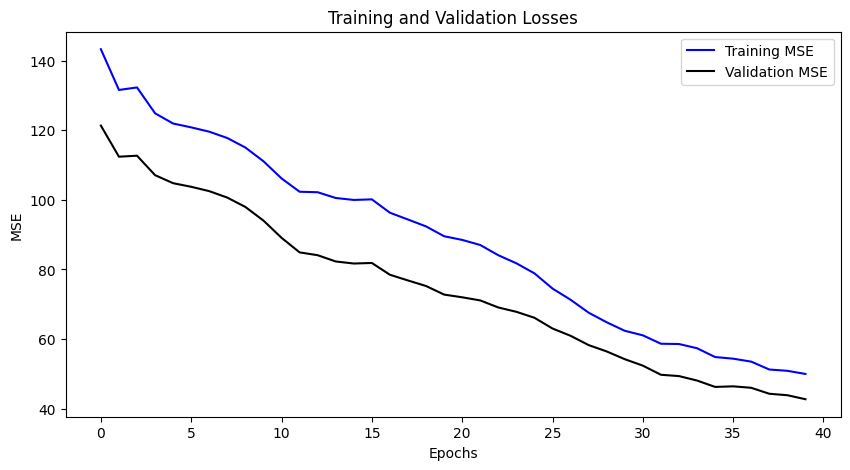

In [20]:
lr = 0.01
batch_size = 100
# path = drive_path + f"model1_nt_{nt}_lr_{lr}_bs_{batch_size}"
GNN_model = GNN()

L_sparse = ssparse.csr_matrix(np.diag(np.diag(L)) -L)
edge_index, edge_weight = tg.utils.from_scipy_sparse_matrix(L_sparse)

edge_weight = edge_weight.to(dtype=torch.float32)

yt_train = torch.tensor(xt_total, dtype=torch.float32)
xt_train = torch.tensor(yt_total, dtype=torch.float32)

# NOTE: yt is the input for the model, and xt is the label, in Data object x is the input and y is the label!
total_data = [Data(x=yt_train[i].unsqueeze(-1), y=xt_train[i].unsqueeze(-1), edge_index=edge_index, edge_attr=edge_weight) for i in range(len(yt_train))]

train_data = total_data[:int(len(total_data) * 0.8)]
valid_data = total_data[int(len(total_data) * 0.8):]

GNN_model.to(device)

train_mse, valid_mse, best_state_dict, best_val_loss = train_model(GNN_model, train_data, valid_data, batch_size=batch_size, lr = lr, path=path, device=device)
torch.save(best_state_dict, drive_path + f"models/model1_nt_{nt}_lr_{lr}_bs_{batch_size}_loss_{best_val_loss}.pk")

plot_learning_curve(train_mse, valid_mse)

## Part 4: Comparison

In [17]:
GNN_model = GNN()
GNN_model.load_state_dict(torch.load(path))

valid_loader = DataLoader(valid_data, batch_size=100, shuffle=False)



In [ ]:
xt_test, yt_test = generate_data(nt, Y, Lambda, V )
test_estimator_mse(h_gsp, b_gsp, xt_test, yt_test, V)

In [ ]:
h_gsp, b_gsp = train_gsp_lmmse_estimator(xt_total, yt_total, V)